In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd
import pickle
import csv

from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from PIL import Image
from numpy import asarray

In [2]:
train_label = pd.read_csv('dataset/glaucoma.csv')
y_train = train_label['Glaucoma']
train_label.head()

,Filename,ExpCDR,Eye,Set,Glaucoma
0,001.jpg,0.7097,OD,A,0
1,002.jpg,0.6953,OS,A,0
2,003.jpg,0.9629,OS,A,0
3,004.jpg,0.7246,OD,A,0
4,005.jpg,0.6138,OS,A,0


In [3]:
image = Image.open('dataset/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation/Glaucoma_Positive/613.jpg')
# summarize some details about the image
print(image.format)
print(image.mode)
print(image.size)
# show the image
image.show()
pixels = asarray(image)

JPEG
RGB
(3072, 2048)


In [4]:
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# global centering of pixels
pixels = pixels - mean
# confirm it had the desired effect
mean = pixels.mean()
print('Mean: %.3f' % mean)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)

Mean: 73.462
Min: 0.000, Max: 255.000
Mean: 0.000
Min: -73.462, Max: 181.538
[[[-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  ...
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]]

 [[-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  ...
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]]

 [[-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  [-71.46201356 -71.46201356 -73.46201356]
  ...
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]
  [-72.46201356 -72.46201356 -73.46201356]]

 ...

 [[-73.46201356 -73.46201356 -73.46201356]
  [-73.46201356 -73.46201356 -73.46201356]
  [-73.46201356 -73.46201356 -73.

In [5]:
print('Data Type: %s' % pixels.dtype)
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
# convert from integers to floats
pixels = pixels.astype('float32')
# normalize to the range 0-1
pixels /= 255.0
mean = pixels.mean()
print('pixel mean = ', mean)

# confirm the normalization
print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
print(pixels)

Data Type: float64
Min: -73.462, Max: 181.538
pixel mean =  1.3986008e-09
Min: -0.288, Max: 0.712
[[[-0.2802432  -0.2802432  -0.28808632]
  [-0.2802432  -0.2802432  -0.28808632]
  [-0.2802432  -0.2802432  -0.28808632]
  ...
  [-0.28416476 -0.28416476 -0.28808632]
  [-0.28416476 -0.28416476 -0.28808632]
  [-0.28416476 -0.28416476 -0.28808632]]

 [[-0.2802432  -0.2802432  -0.28808632]
  [-0.2802432  -0.2802432  -0.28808632]
  [-0.2802432  -0.2802432  -0.28808632]
  ...
  [-0.28416476 -0.28416476 -0.28808632]
  [-0.28416476 -0.28416476 -0.28808632]
  [-0.28416476 -0.28416476 -0.28808632]]

 [[-0.2802432  -0.2802432  -0.28808632]
  [-0.2802432  -0.2802432  -0.28808632]
  [-0.2802432  -0.2802432  -0.28808632]
  ...
  [-0.28416476 -0.28416476 -0.28808632]
  [-0.28416476 -0.28416476 -0.28808632]
  [-0.28416476 -0.28416476 -0.28808632]]

 ...

 [[-0.28808632 -0.28808632 -0.28808632]
  [-0.28808632 -0.28808632 -0.28808632]
  [-0.28808632 -0.28808632 -0.28808632]
  ...
  [-0.28416476 -0.28416476

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


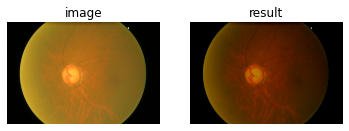

In [6]:
import matplotlib.pyplot as plt
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.imshow(image)
ax0.axis('off')
ax0.set_title('image')
ax1.imshow(pixels)
ax1.axis('off')
ax1.set_title('result')
plt.show()

In [7]:
from skimage import io

def imshow(image_RGB):
  io.imshow(image_RGB)
  io.show()

In [8]:
from tensorflow.keras.applications.mobilenet import preprocess_input

In [9]:
TRAIN_DIR = 'dataset/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Train'

TEST_DIR = 'dataset/Fundus_Train_Val_Data/Fundus_Scanes_Sorted/Validation'

In [10]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import mobilenet
from keras.models import Sequential, Model, load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, Callback,TensorBoard
from tensorflow.keras.optimizers import SGD, Adam
from keras import regularizers
import keras


HEIGHT = 300
WIDTH = 300

BATCH_SIZE = 8
class_list = ["class_1", "class_2"]
FC_LAYERS = [1024, 512, 256]
dropout = 0.5
NUM_EPOCHS = 25
BATCH_SIZE = 8

# def build_model(base_model, dropout, fc_layers, num_classes):
#     for layer in base_model.layers:
#         layer.trainable = False

#     x = base_model.output
#     x = Flatten()(x)
#     for fc in fc_layers:
#         print(fc)
#         x = Dense(fc, activation='relu')(x)
#         x = Dropout(dropout)(x)
#     preditions = Dense(num_classes, activation='softmax')(x)
#     finetune_model = Model(inputs = base_model.input, outputs = preditions)
#     return finetune_model

def build_model(base_model, dropout, fc_layers, num_classes):
    
    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        print(fc)
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    
    return model

base_model_1 = mobilenet.MobileNet(weights='imagenet',
                                     include_top=False,
                                     input_shape = (HEIGHT, WIDTH, 3))

# train_datagen = ImageDataGenerator(
#     rescale=1. / 255,
#     #shear_range=0.2,
#     zoom_range=0.2,
#     #fill_mode = 'constant',
#     #cval = 1,
#     rotation_range = 5,
#     #width_shift_range=0.2,
#     #height_shift_range=0.2,
#     horizontal_flip=True)

# test_datagen = ImageDataGenerator(rescale=1. / 255)

# train_generator = train_datagen.flow_from_directory(
#     train_data_dir,
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='categorical')

# validation_generator = test_datagen.flow_from_directory(
#     validation_data_dir,
#     target_size=(img_width, img_height),
#     batch_size=batch_size,
#     class_mode='categorical')

train_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                   rotation_range = 90,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.1,)

test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input,
                                  rotation_range = 90,
                                  horizontal_flip = True,
                                  vertical_flip = False)
train_generator = train_datagen.flow_from_directory(TRAIN_DIR,
                                                    target_size = (HEIGHT, WIDTH),
                                                    batch_size = BATCH_SIZE)

test_generator = test_datagen.flow_from_directory(TEST_DIR,
                                                  target_size = (HEIGHT, WIDTH),
                                                  batch_size = BATCH_SIZE)



mobilenet_model = build_model(base_model_1,
                                      dropout = dropout,
                                      fc_layers = FC_LAYERS,
                                      num_classes = len(class_list))

adam = Adam(lr = 0.00001)
mobilenet_model.compile(adam, loss="binary_crossentropy", metrics=["accuracy"])

filepath = "./checkpoints" + "Mobilenet" + "_model_weights.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor = ["acc"], verbose= 1, mode = "max")
cb=TensorBoard(log_dir=("/home/ubuntu/"))
callbacks_list = [checkpoint, cb]

print(train_generator.class_indices)

mobilenet_model.summary()

17235968/17225924 [==============================] - 4s 0us/step
Found 520 images belonging to 2 classes.
Found 130 images belonging to 2 classes.
1024
512
256
{'Glaucoma_Negative': 0, 'Glaucoma_Positive': 1}
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 150, 150, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 150, 150, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 150, 150, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 150, 150, 32)

C:\Users\HP\Anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
history = mobilenet_model.fit_generator(generator = train_generator, epochs = NUM_EPOCHS, steps_per_epoch = 25, 
                                       shuffle = True, validation_data = test_generator)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


Epoch 1/25
25/25 [==============================] - 59s 2s/step - loss: 1.5696 - accuracy: 0.5150 - val_loss: 0.9040 - val_accuracy: 0.7385
Epoch 2/25
25/25 [==============================] - 51s 2s/step - loss: 1.2646 - accuracy: 0.6550 - val_loss: 1.0915 - val_accuracy: 0.7385
Epoch 3/25
25/25 [==============================] - 50s 2s/step - loss: 1.1310 - accuracy: 0.7300 - val_loss: 0.8957 - val_accuracy: 0.7385
Epoch 4/25
25/25 [==============================] - 50s 2s/step - loss: 1.0812 - accuracy: 0.6450 - val_loss: 0.7525 - val_accuracy: 0.7385
Epoch 5/25
25/25 [==============================] - 49s 2s/step - loss: 1.1592 - accuracy: 0.5950 - val_loss: 0.6832 - val_accuracy: 0.7385
Epoch 6/25
25/25 [==============================] - 50s 2s/step - loss: 0.8596 - accuracy: 0.6950 - val_loss: 0.7754 - val_accuracy: 0.7385
Epoch 7/25
25/25 [==============================] - 50s 2s/step - loss: 1.1043 - accuracy: 0.6700 - val_loss: 0.6857 - val_accuracy: 0.7385
Epoch 8/25
25/25 [==

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


8
[1. 0.]


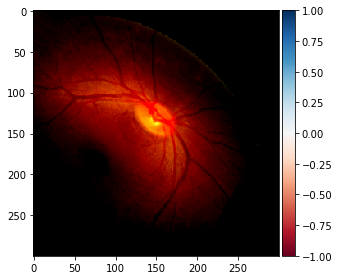

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


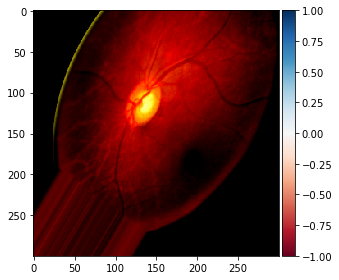

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


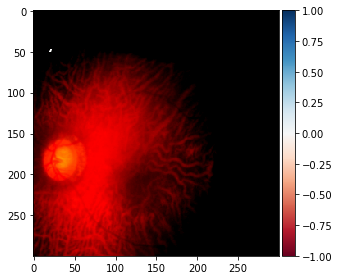

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


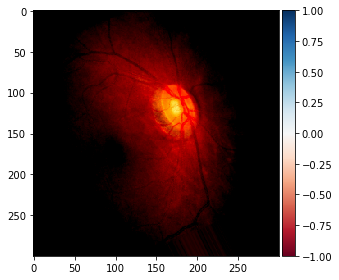

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


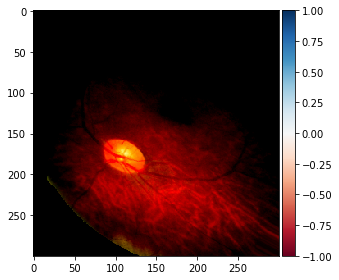

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


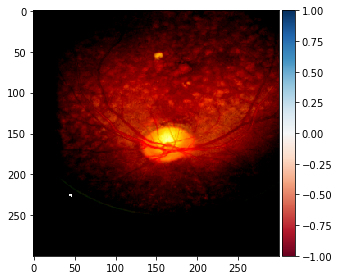

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[1. 0.]


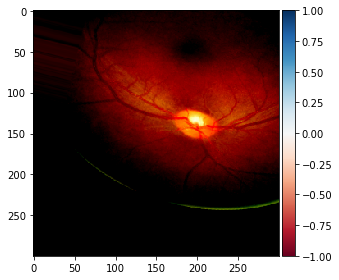

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[0. 1.]


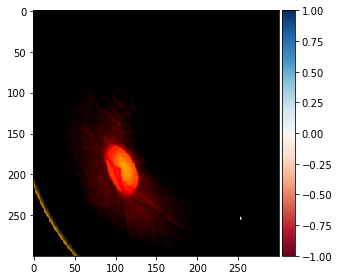

In [12]:
image_batch,label_batch = train_generator.next()

print(len(image_batch))
for i in range(0,len(image_batch)):
    image = image_batch[i]
    print(label_batch[i])
    imshow(image)

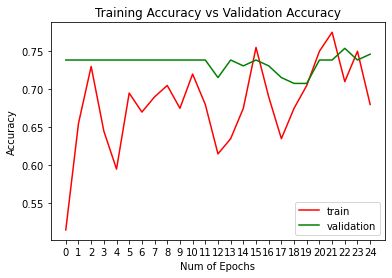

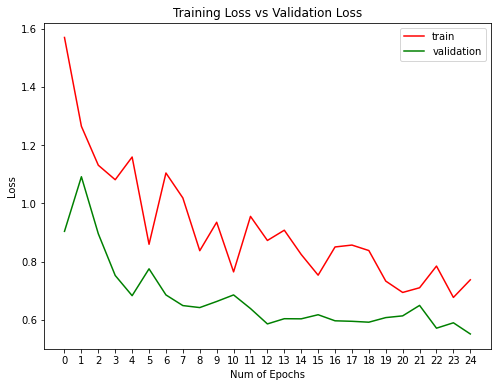

In [13]:
plt.figure(0)
plt.plot(history.history['accuracy'],'r')
plt.plot(history.history['val_accuracy'],'g')
plt.xticks(np.arange(0, 25, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("Training Accuracy vs Validation Accuracy")
plt.legend(['train','validation'])
 
plt.figure(1)
plt.plot(history.history['loss'],'r')
plt.plot(history.history['val_loss'],'g')
plt.xticks(np.arange(0, 25, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("Training Loss vs Validation Loss")
plt.legend(['train','validation'])

 
plt.show()

In [14]:
mobilenet_model.evaluate_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.5590378642082214, 0.7076923251152039]

In [15]:
pred = mobilenet_model.predict_generator(test_generator, steps=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=1)
predicted = np.argmax(pred, axis=1)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


17/17 [==============================] - 15s 837ms/step


Confusion Matrix


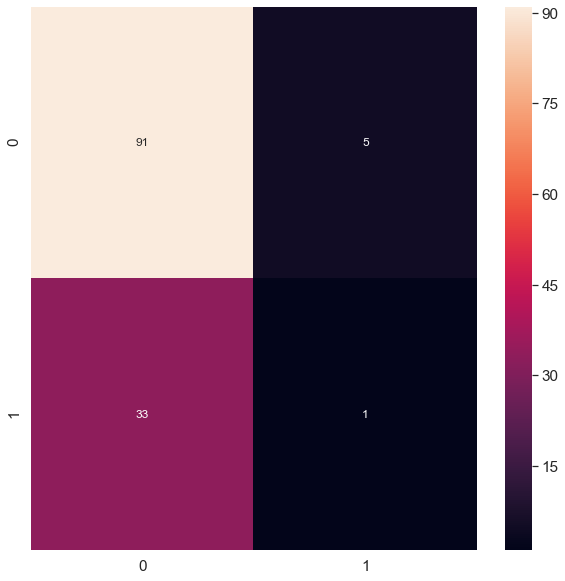


Classification Report
              precision    recall  f1-score   support

           0       0.73      0.95      0.83        96
           1       0.17      0.03      0.05        34

    accuracy                           0.71       130
   macro avg       0.45      0.49      0.44       130
weighted avg       0.59      0.71      0.62       130



In [16]:
print('Confusion Matrix')
cm = confusion_matrix(test_generator.classes, np.argmax(pred, axis=1))
plt.figure(figsize = (10,10))
sn.set(font_scale=1.4) #for label size
sn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()
print()
print('Classification Report')
print(classification_report(test_generator.classes, predicted))